In [34]:
%tensorflow_version 2.x

import tensorflow as tf
from tensorflow import keras
print("tf version {0} executing eagerly is {1}".format(tf.__version__, tf.executing_eagerly()))

import tensorflow_probability as tfp
print("tfp version {0}".format(tfp.__version__))

tf version 2.2.0-rc1 executing eagerly is True
tfp version 0.9.0


In [35]:
from google.colab import drive
drive.mount('/content/drive')
BASE_DIR = '/content/drive/My Drive/StoicNetData/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
device_name = tf.test.gpu_device_name()
print("Device name: \"{0}\"".format(device_name))
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

Device name: "/device:GPU:0"
Found GPU at: /device:GPU:0
1 Physical GPUs, 1 Logical GPUs


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import cv2
import sys
import os
import time
import numpy as np
import glob
import PIL
import imageio
import matplotlib.pyplot as plt
from IPython import display

import warnings
warnings.simplefilter('error', UserWarning)
warnings.filterwarnings("error")

In [0]:
tf.random.set_seed(98475651423)

In [0]:
IMG_HEIGHT = 112
IMG_WIDTH = 112

keys_to_features = {
    'image_neutral': tf.io.FixedLenFeature([], tf.string),
    'image_expressive': tf.io.FixedLenFeature([], tf.string),
    'image_other': tf.io.FixedLenFeature([], tf.string)
}

def parser(record):
    parsed = tf.io.parse_single_example(record, keys_to_features)
    
    imageNeutral = tf.io.decode_raw(parsed["image_neutral"], tf.uint8)
    imageExpressive = tf.io.decode_raw(parsed["image_expressive"], tf.uint8)
    imageOther = tf.io.decode_raw(parsed["image_other"], tf.uint8)
    
    imageNeutral = tf.cast(imageNeutral, tf.float32)
    imageExpressive = tf.cast(imageExpressive, tf.float32)
    imageOther = tf.cast(imageOther, tf.float32)
    
    imageNeutral = tf.reshape(imageNeutral, shape=[224,224,1])
    imageExpressive = tf.reshape(imageExpressive, shape=[224,224,1])
    imageOther = tf.reshape(imageOther, shape=[224,224,1])

    imageNeutral = tf.image.resize(imageNeutral, size=[IMG_HEIGHT,IMG_WIDTH])
    imageExpressive = tf.image.resize(imageExpressive, size=[IMG_HEIGHT,IMG_WIDTH])
    imageOther = tf.image.resize(imageOther, size=[IMG_HEIGHT,IMG_WIDTH])

    imageNeutral /= (255/2)
    imageExpressive /= (255/2)
    imageOther /= (255/2)
    imageNeutral -= 1
    imageExpressive -= 1
    imageOther -= 1

    return {"imageNeutral":imageNeutral, "imageExpressive":imageExpressive, "imageOther":imageOther}

In [0]:
BUFFER_SIZE = 20000
BATCH_SIZE = 32

DB_PATH = BASE_DIR
raw_train = tf.data.TFRecordDataset(DB_PATH + "train.tfrecords")
raw_test = tf.data.TFRecordDataset(DB_PATH + "test.tfrecords")

raw_novel = tf.data.TFRecordDataset(DB_PATH + "novel.tfrecords")
parsed_novel = raw_novel.map(parser)

#raw_val = raw_test.shard(2,0)
#raw_test = raw_test.shard(2,1)

parsed_train = raw_train.map(parser).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
#parsed_val = raw_val.map(parser).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
parsed_test = raw_test.map(parser).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

latent_dim = 64 #100

In [0]:
class Recognizer(tf.keras.Model):
    def __init__(self, latent_dim):
        super(Recognizer, self).__init__()
        self.encoder = tf.keras.models.Sequential(layers=[
            tf.keras.layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),
 
            tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2,2)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2,2)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(2,2)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=(2,2)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim)
        ], name="encoder")

        self.comparer = tf.keras.models.Sequential(layers=[
            tf.keras.layers.InputLayer(input_shape=(latent_dim)),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ], name="comparer")

    
    @tf.function
    def recognize(self, a, b):
        a_encoding = self.encode(a)
        b_encoding = self.encode(b)

        return self.decide(a_encoding, b_encoding)
    
    @tf.function
    def encode(self, x):
        encoding = self.encoder(x)
        return encoding

    @tf.function
    def decide(self, a_enc, b_enc):
        diffs = tf.abs(a_enc - b_enc)
        prediction = self.comparer(diffs)
        return prediction

recognizer = Recognizer(latent_dim)
# Start with the mostly pretrained model?
#recognizer.load_weights(BASE_DIR + 'saved_model/recognizerWeights')

In [0]:
init = tf.random_normal_initializer(mean=0.0, stddev=0.02, seed=918273645)

class Encoder(tf.keras.Model):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.latent_dim = latent_dim
        self.encode = tf.keras.models.Sequential(layers=[
            tf.keras.layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),

            tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2,2), kernel_initializer=init),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2,2), kernel_initializer=init),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(2,2), kernel_initializer=init),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=(2,2), kernel_initializer=init),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim + latent_dim, kernel_initializer=init), # no activation...
        ], name="encode")
    
    @tf.function
    def __call__(self, x):
        mean, logvar = tf.split(self.encode(x), num_or_size_splits=2, axis=1)
        return mean, logvar


class Decoder(tf.keras.Model):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.latent_dim = latent_dim
        self.decode = tf.keras.models.Sequential(layers=[
            tf.keras.layers.InputLayer(input_shape=(latent_dim)),

            tf.keras.layers.Dense(units=7*7*256),
            tf.keras.layers.Reshape(target_shape=(7, 7, 256)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2DTranspose(
                filters=128, kernel_size=4, strides=(2, 2), padding="SAME", use_bias=False, kernel_initializer=init),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=4, strides=(2, 2), padding="SAME", use_bias=False, kernel_initializer=init),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=4, strides=(2, 2), padding="SAME", use_bias=False, kernel_initializer=init),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2DTranspose(
                filters=16, kernel_size=4, strides=(2, 2), padding="SAME", use_bias=False, kernel_initializer=init),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=(1, 1), padding="SAME", use_bias=False, kernel_initializer=init,
                activation="tanh"),
        ], name="decode")

    @tf.function
    def __call__(self, x):
        return self.decode(x)


@tf.function
def reparameterize(mean, logvar):
    # Logvar used for numerical stability
    epsilon = tf.random.normal(shape=mean.shape)
    return epsilon * tf.exp(logvar * .5) + mean

@tf.function
def generateImg(enc, dec, x):
    mean, logvar = enc(x)
    return generateDist(dec, mean, logvar)

@tf.function
def generateDist(dec, mean, logvar):
    z = reparameterize(mean, logvar)
    return dec(z)

@tf.function
def generatePrecise(enc, dec, x):
    z, _ = enc(x)
    return dec(z)

In [0]:
class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminate = tf.keras.models.Sequential(layers=[
            tf.keras.layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),

            tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2,2), kernel_initializer=init),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),

            tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2,2), kernel_initializer=init),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),

            tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(2,2), kernel_initializer=init),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),

            tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=(2,2), kernel_initializer=init),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(512, kernel_initializer=init),
            tf.keras.layers.LeakyReLU(),

            tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=init),
        ], name="discriminate")
    
    @tf.function
    def __call__(self, x):
        return self.discriminate(x)


In [0]:
class QuadrupletLoss(tf.keras.losses.Loss):
    def __init__(self, delta):
        super(QuadrupletLoss, self).__init__()
        self.delta = delta

    def call(self, y_true, y_pred):
        # anchor         positive         negative         generated negative
        anc = y_pred[0]; pos = y_pred[1]; neg = y_pred[2]; gneg = y_pred[3]
        
        # typically use tf.reduce_sum(tf.square(tf.subtract(
        # but some papers have suggested not squaring:
        # tf.reduce_sum(tf.subtract(

        # distance between the anchor and the positive
        anc_pos_dist = tf.reduce_sum(tf.square(tf.subtract(anc, pos)), axis=-1)    
        # distance between the anchor and the negative
        anc_neg_dist = tf.reduce_sum(tf.square(tf.subtract(anc, neg)), axis=-1)
        # distance between the anchor and the generated negative
        anc_gneg_dist = tf.reduce_sum(tf.square(tf.subtract(anc, gneg)), axis=-1)
        
        trip_pos_neg = tf.math.maximum(tf.add(tf.subtract(anc_pos_dist, anc_neg_dist), self.delta), 0.0)
        trip_pos_gneg = tf.math.maximum(tf.add(tf.subtract(anc_pos_dist, anc_gneg_dist), self.delta), 0.0)

        return tf.add(trip_pos_neg, trip_pos_gneg)

encOptimizer = tf.keras.optimizers.Adam(learning_rate=0.00005, beta_1=0.5)
decOptimizer = tf.keras.optimizers.Adam(learning_rate=0.00005, beta_1=0.5)
disOptimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
idenOptimizer = tf.keras.optimizers.Adam(learning_rate=0.00006, beta_1=0.5)

prior = tfp.distributions.MultivariateNormalDiag(tf.zeros(latent_dim), tf.ones(latent_dim))
N = tf.convert_to_tensor(IMG_HEIGHT * IMG_WIDTH, dtype=tf.float32)
M = tf.convert_to_tensor(BATCH_SIZE, dtype=tf.float32)
reconstructionMult = tf.math.divide(N, M)


def add_noise(x):
    noise_intensity = 1.0
    noise = tf.multiply(noise_intensity, tf.random.normal(shape=x.shape, mean=0.0, stddev=0.3))
    return tf.clip_by_value(tf.add(x, noise), -1.0, 1.0)


@tf.function
def compute_apply_gradients(enc, dec, dis, iden, x_neutral, x_express, x_other, encOptimizer, decOptimizer, disOptimizer, idenOptimizer, alpha, beta, gammaD, gammaE):
    # Do a quick identity training.
    with tf.GradientTape() as idenTape:
        idenloss = id_speed_round(iden, enc, dec, x_neutral, x_express, x_other)
    gradients_of_iden = idenTape.gradient(idenloss, iden.trainable_variables)
    idenOptimizer.apply_gradients(zip(gradients_of_iden, iden.trainable_variables))
    
    # Do full training
    with tf.GradientTape(persistent=True) as tape:
        encloss, decloss, disloss, idenloss = compute_loss(enc, dec, dis, iden,
                                                           x_neutral, x_express, x_other,
                                                           alpha, beta, gammaD, gammaE)

    gradients_of_enc = tape.gradient(encloss, enc.trainable_variables)
    gradients_of_dec = tape.gradient(decloss, dec.trainable_variables)
    gradients_of_dis = tape.gradient(disloss, dis.trainable_variables)
    gradients_of_iden = tape.gradient(idenloss, iden.trainable_variables)

    encOptimizer.apply_gradients(zip(gradients_of_enc, enc.trainable_variables))
    decOptimizer.apply_gradients(zip(gradients_of_dec, dec.trainable_variables))
    disOptimizer.apply_gradients(zip(gradients_of_dis, dis.trainable_variables))
    idenOptimizer.apply_gradients(zip(gradients_of_iden, iden.trainable_variables))


#@tf.function
def compute_loss(enc, dec, dis, iden, x_neutral, x_express, x_other, alpha, beta, gammaD, gammaE):
    #Compute loss values
    klLoss, recLoss, decGanLoss, disGanLoss, presLoss, idenLoss = compute_ALL_loss(enc, dec, dis, iden,
                                                                                   x_neutral, x_express, x_other)

    presLoss  = tf.math.multiply(alpha, presLoss)

    # Group them up for each network
    encLoss = tf.math.add(
        tf.math.add(
            tf.math.multiply(beta,  klLoss),
            tf.math.multiply(gammaE, recLoss)),
        presLoss) # (B * Lkl) + Lr + (A*Lp)
    decLoss = tf.math.add(
        tf.math.add(
            tf.math.multiply(gammaD, recLoss),
            decGanLoss),
        presLoss) # (G * Lr) - Lg + (A*Lp)
    disLoss = disGanLoss
    idenLoss = idenLoss

    return encLoss, decLoss, disLoss, idenLoss


#@tf.function
def compute_ALL_loss(enc, dec, dis, iden, x_neutral, x_express, x_other):
    mean_e, logvar_e = enc(x_express)

    # KL Divergence Loss
    posterior = tfp.distributions.MultivariateNormalDiag(mean_e, tf.exp(logvar_e * .5))
    divergenceLoss = tf.reduce_mean(tfp.distributions.kl_divergence(posterior, prior))

    generated_images = generateDist(dec, mean_e, logvar_e)
    generated_images_precise = dec(mean_e)

    # Reconstruction Loss
    reconstructionLoss = tf.math.multiply(reconstructionMult, tf.math.sqrt(tf.reduce_mean(tf.math.square(tf.math.subtract(x_neutral, generated_images_precise)))))

    # Let the discriminator discriminate
    real_decisions = dis(add_noise(x_neutral))
    fake_decisions = dis(add_noise(generated_images))
    samples = tf.random.normal(shape=[generated_images.shape[0], latent_dim])
    sample_decisions = dis(add_noise(dec(samples)))

    # Discriminator-based Loss
    genGanLoss, disGanLoss = compute_gan_loss(real_decisions, fake_decisions, sample_decisions)

    # VAE loss from not preserving identity
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    presScores = iden.recognize(x_express, generated_images)
    preserveLoss = cross_entropy(tf.ones_like(presScores), presScores)

    # Loss for the identity recognition network
    identityLoss = compute_id_loss(iden, x_neutral, x_express, x_other, generated_images_precise)

    return divergenceLoss, reconstructionLoss, genGanLoss, disGanLoss, preserveLoss, identityLoss


#@tf.function
def compute_gan_loss(real_output, fake_output, sample_output=None):
    dis_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False, label_smoothing=0.1)
    gen_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    real_labels = tf.ones_like(real_output)
    fake_labels = tf.zeros_like(fake_output)

    # Loss from identitifation of real images
    dis_real_loss = dis_cross_entropy(real_labels, real_output) # Try not to be fooled
    
    # Loss from identitifation of fake images
    dis_fake_loss = dis_cross_entropy(fake_labels, fake_output) # Try not to be fooled
    gen_fake_loss = gen_cross_entropy(real_labels, fake_output) # Try to fool
    
    if not sample_output is None:
        # Loss from identitifation of fake sampled images
        gen_sample_loss = gen_cross_entropy(real_labels, sample_output) # Try to fool
        dis_sample_loss = dis_cross_entropy(fake_labels, sample_output) # Try not to be fooled
    
    if not sample_output is None:
        # For generator: FakeLoss + SampleLoss
        gen_gan_loss = tf.math.add(gen_fake_loss, gen_sample_loss)
        # For discriminator: RealLoss + FakeLoss + SampleLoss
        dis_gan_loss = tf.math.add(tf.math.add(dis_real_loss, dis_fake_loss), dis_sample_loss)
    else:
        # For generator: FakeLoss
        gen_gan_loss = gen_fake_loss
        # For discriminator: RealLoss + FakeLoss
        dis_gan_loss = tf.math.add(dis_real_loss, dis_fake_loss)
    return gen_gan_loss, dis_gan_loss

def id_speed_round(iden, enc, dec, x_neutral, x_express, x_other):
    mean_e, logvar_e = enc(x_express)
    generated_images_precise = dec(mean_e)
    return compute_id_loss(iden, x_neutral, x_express, x_other, generated_images_precise)

def compute_id_loss(iden, x_neutral, x_express, x_other, x_gen):
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    quadruplet_loss = QuadrupletLoss(tf.convert_to_tensor(0.2, dtype=tf.float32))

    e_neutral = iden.encode(tf.convert_to_tensor(x_neutral, tf.float32))
    e_express = iden.encode(tf.convert_to_tensor(x_express, tf.float32))
    e_other = iden.encode(tf.convert_to_tensor(x_other, tf.float32))
    e_gen = iden.encode(tf.convert_to_tensor(x_gen, tf.float32))

    # Encoding losses
    ql = quadruplet_loss([], [e_express, e_neutral, e_other, e_gen])

    # Prediction losses
    pos_preds = iden.decide(e_express, e_neutral)   # anchor, positive
    neg_preds = iden.decide(e_express, e_other)     # anchor, negative
    gen_preds = iden.decide(e_express, e_gen)       # anchor, gen. neg.
    
    pos_labels = tf.ones_like(pos_preds)
    neg_labels = tf.zeros_like(neg_preds)

    pos_loss = cross_entropy(pos_labels, pos_preds)
    neg_loss = cross_entropy(neg_labels, neg_preds)
    gen_loss = cross_entropy(neg_labels, gen_preds)

    return ql + (pos_loss + neg_loss + gen_loss)


In [0]:
epochs = 150
num_examples_to_generate = 16

random_vector_for_generation = tf.random.normal(shape=[num_examples_to_generate, latent_dim])
random_images_for_generation = [image_features['imageExpressive'] for image_features in parsed_test.take(1)][0][0:num_examples_to_generate]

encoder = Encoder(latent_dim)
decoder = Decoder(latent_dim)
discriminator = Discriminator()

In [0]:
# setup checkpoint stuff
checkpoint_dir = BASE_DIR + 'training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckptEpoch{}")
checkpoint = tf.train.Checkpoint(encOptimizer=encOptimizer,
                                 decOptimizer=decOptimizer,
                                 disOptimizer=disOptimizer,
                                 idenOptimizer=idenOptimizer,
                                 encoder=encoder,
                                 decoder=decoder,
                                 discriminator=discriminator,
                                 recognizer=recognizer)

In [0]:
def save_images(epoch, test_input):
    imgs = decoder(test_input)
    assert not np.any(np.isnan(imgs))
    fig = plt.figure(figsize=(4,4))
    ds = discriminator(imgs)
    for i in range(imgs.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.gca().set_title("{0:.4f}".format(ds[i,0]))
        plt.imshow(imgs[i, :, :, 0], cmap='gray')
        plt.axis('off')
    fig.tight_layout()
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    #plt.close(fig)

def display_novel_images():
    for image_features in parsed_novel:
        first = image_features['imageNeutral']
        second = image_features['imageExpressive']
        third = image_features['imageOther']
        test_input = np.array([first, second, third])

        images = generatePrecise(encoder, decoder, test_input[0:3])
        rs = recognizer.recognize(test_input[0:3], images)
        ims = np.concatenate((test_input[0:3], images), axis=0)
        assert not np.any(np.isnan(ims))
        fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(6,4))
        for i in range(ims.shape[0]):
            c = i % 3
            r = i // 3
            axes[r, c].imshow(ims[i, :, :, 0], cmap='gray')
            axes[r, c].set_yticklabels([])
            axes[r, c].xaxis.set_visible(False)
        axes[0,0].set_ylabel("Inputs", size='large')
        axes[1,0].set_ylabel("Generated", size='large')
        fig.tight_layout()
        plt.savefig('novel_outputs.png')

def display_imgs_ratings(test_input, epoch=-1):
    images = generateImg(encoder, decoder, test_input[0:8])
    rs = recognizer.recognize(test_input[0:8], images)
    ims = np.concatenate((test_input[0:8], images), axis=0)
    assert not np.any(np.isnan(ims))
    fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(11,4))
    ds = discriminator(ims)
    for i in range(ims.shape[0]):
        c = i % 8
        r = i // 8
        if r == 1:
            axes[r, c].set_title("d {0:.6f}\nr {1:.4f}".format(ds[i,0], rs[c,0]))
        else: 
            axes[r, c].set_title("d {0:.6f}".format(ds[i,0]))
        axes[r, c].imshow(ims[i, :, :, 0], cmap='gray')
        axes[r, c].set_yticklabels([])
        axes[r, c].xaxis.set_visible(False)
    axes[0,0].set_ylabel("Inputs", size='large')
    axes[1,0].set_ylabel("Generated", size='large')
    fig.tight_layout()
    if epoch >= 0:
        plt.savefig('gens_ratings_at_epoch_{:04d}.png'.format(epoch))
        plt.close(fig)
    else:
        plt.show()

def plot_ALL_loss(ls):
    kl, rl, gl, dl, pl, il = zip(*ls)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.yaxis.tick_right()
    plt.plot(kl, '-b', label='kL')
    plt.plot(rl, '-g', label='rL')
    plt.plot(gl, '-r', label='gL')
    plt.plot(dl, '-m', label='dL')
    plt.plot(pl, '-y', label='pL')
    plt.plot(il, '-k', label='il')
    plt.title("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Training Stuff

In [48]:
FRESH = True
if not FRESH:
    c = tf.train.latest_checkpoint(checkpoint_dir)
    print("Restoring checkpoint {0}".format(c))
    checkpoint.restore(c).assert_consumed()
    startEpoch = max(alpha_ramp_end,beta_ramp_end, gammaD_ramp_end)
else:
    print("Training a fresh model")
    startEpoch = 0

Training a fresh model


Epoch 42, Total epoch time 80.4
Losses: k 2.57423(2.57423) r 0.00000(149.02277) g 5.92999(5.92999) d 0.59622(0.59622) p 2.50747(0.68386) i 0.03474(0.03474)
Alpha(p): 3.667, Beta(k): 1.000, GammaD(r): 0.000


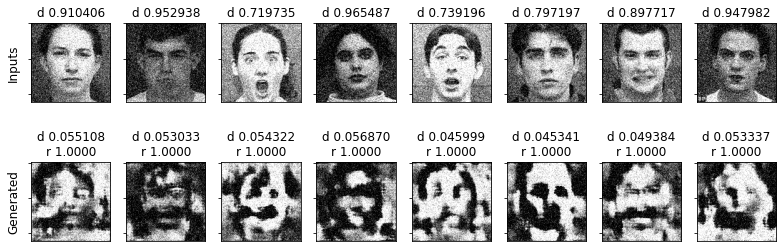

In [0]:
alpha = 0.0         # Alpha weights identity preservation loss.
max_alpha = 5.0
alpha_ramp_start = 20   # Ramps up
alpha_ramp_end = 30

beta = 0.0      # Beta weighs KL Divergence loss.
max_beta = 1.0
beta_ramp_start = -1   # Ramps up
beta_ramp_end = 10

gammaD = 0.05    # Gamma weighs reconstruction loss for the decoder
max_gammaD = 0.05
min_gammaD = 0.0
gammaD_ramp_end = 30   # Ramps down

gammaE = 0.05   # Gamma2 weighs reconstruction loss for the encoder (constant)

ls = []
bestLoss = 999999.9
for epoch in range(startEpoch, epochs-startEpoch):

    # Train
    print("\nTraining", end="")
    start_time = time.time()
    batchCounter = 0

    alpha = min(max_alpha, max_alpha * (max(0,(epoch - alpha_ramp_start)) / alpha_ramp_end))
    alpha = tf.convert_to_tensor(alpha, dtype=tf.float32)
    beta = min(max_beta, max_beta * (max(0, (epoch - beta_ramp_start)) / beta_ramp_end))
    beta = tf.convert_to_tensor(beta, dtype=tf.float32)
    gammaD = min_gammaD + max_gammaD * max(0, 1 - (epoch / gammaD_ramp_end))
    gammaD = tf.convert_to_tensor(gammaD, dtype=tf.float32)

    for image_features in parsed_train:
        neutral_raw = image_features['imageNeutral']
        expressive_raw = image_features['imageExpressive']
        other_raw = image_features['imageOther']

        compute_apply_gradients(
            encoder, decoder, discriminator, recognizer,
            neutral_raw, expressive_raw, other_raw,
            encOptimizer, decOptimizer, disOptimizer, idenOptimizer,
            alpha, beta, gammaD, gammaE)

        batchCounter += 1
        if batchCounter % 10 == 0:
            print(".", end="")
    
    # Test
    print("\nTesting", end="")
    batchCounter = 0
    kloss = tf.keras.metrics.Mean()
    rloss = tf.keras.metrics.Mean()
    gloss = tf.keras.metrics.Mean()
    dloss = tf.keras.metrics.Mean()
    ploss = tf.keras.metrics.Mean()
    iloss = tf.keras.metrics.Mean()
    for image_features in parsed_test:
        neutral_raw = image_features['imageNeutral']
        expressive_raw = image_features['imageExpressive']
        other_raw = image_features['imageOther']

        kl, rl, gl, dl, pl, il = compute_ALL_loss(
            encoder, decoder, discriminator, recognizer,
            neutral_raw, expressive_raw, other_raw)
        
        kloss(kl)
        rloss(rl)
        gloss(gl)
        dloss(dl)
        ploss(pl)
        iloss(il)

        batchCounter += 1
        if batchCounter % 10 == 0:
            print(".", end="")

    klr = kloss.result().numpy()
    kl = tf.math.multiply(kloss.result(), beta).numpy()
    rlr = rloss.result().numpy()
    rl = tf.math.multiply(rloss.result(), gammaD).numpy()
    glr = gloss.result().numpy()
    gl = gloss.result().numpy()
    dlr = dloss.result().numpy()
    dl = dloss.result().numpy()
    plr = ploss.result().numpy()
    pl = tf.math.multiply(ploss.result(), alpha).numpy()
    ilr = iloss.result().numpy()
    il = iloss.result().numpy()
    ls = ls + [(kl, rl, gl, dl, pl, il)]
    
    end_time = time.time()

    # Output
    display.clear_output(wait=False)
    print('Epoch {0}, Total epoch time {1:.1f}'.format(epoch, end_time-start_time))
    print('Losses: k {0:.5f}({1:.5f}) r {2:.5f}({3:.5f}) g {4:.5f}({5:.5f}) d {6:.5f}({7:.5f}) p {8:.5f}({9:.5f}) i {10:.5f}({11:.5f})'.format(
            kl, klr, rl, rlr, gl, glr, dl, dlr, pl, plr, il, ilr))
    print("Alpha(p): {0:.3f}, Beta(k): {1:.3f}, GammaD(r): {2:.3f}".format(alpha, beta, gammaD))
    display_imgs_ratings(random_images_for_generation)
    save_images(epoch, random_vector_for_generation)
    display_novel_images()
    plot_ALL_loss(ls)

    # Save the model from time to time or if you get a new record (after sufficient training)
    if epoch > 25 and rl + gl + pl < bestLoss:
        bestLoss = rl + gl + pl
        best_checkpoint_prefix = os.path.join(checkpoint_dir, "BEST_CKPT_")
        checkpoint.save(file_prefix=best_checkpoint_prefix)
        print("*Saved new best*")
    elif (epoch + 1) % 10 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix.format(epoch))

    tf.keras.backend.clear_session()

In [0]:
checkpoint_prefix = os.path.join(checkpoint_dir, "FINAL_CKPT_" + time.strftime('%l:%M%b%d'))
checkpoint.save(file_prefix = checkpoint_prefix)

In [0]:
anim_filename = BASE_DIR + 'TrainingGifs/vaegan' + time.strftime('%l:%M %b %d') + '.gif'
print(anim_filename)
with imageio.get_writer(anim_filename, mode='I') as writer:
    filenames = glob.glob('image_at_epoch_*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

# Testing Stuff

In [0]:
checkpointName = "ckpt-4" # "FINAL_CKPT_12:05Mar22-18"
#checkpoint.restore(os.path.join(checkpoint_dir,checkpointName)).assert_nontrivial_match()

In [0]:
display_imgs_ratings(random_images_for_generation)

In [0]:
display_novel_images()
print(encoder(test_input))

In [0]:
save_images(-1, tf.math.scalar_mul(-0.8, tf.ones_like(random_vector_for_generation)))